### 1. Import Dependecies

In [153]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

### 2. Loading the data

In [154]:
X_train = np.load('artifacts/X_train.npz')['arr_0']
Y_train = np.load('artifacts/Y_train.npz')['arr_0']
X_test = np.load('artifacts/X_test.npz')['arr_0']
Y_test = np.load('artifacts/Y_test.npz')['arr_0']

### 3. Model Training

#### 3.1 Simple Boosting

In [155]:
# Decision Tree from Scratch
class TreeNode:
    def __init__(self):
        self.feature_index = None
        self.threshold = None
        self.left = None
        self.right = None
        self.prediction = None

class DecisionTree:
    def __init__(self, maximum_depth=5, criterion='gini'):
        self.maximum_depth = maximum_depth
        self.criterion = criterion
        self.tree = None
    
    def _impurity(self, y):
        if len(y) == 0:
            return 0
        counts = Counter(y)
        n = len(y)
        
        if self.criterion == 'gini':
            return 1 - sum((count/n)**2 for count in counts.values())
        else:  # entropy
            return -sum((count/n) * np.log2(count/n) for count in counts.values() if count > 0)
    
    def _best_split(self, X, y):
        best_gain, best_feature, best_threshold = 0, None, None
        current_impurity = self._impurity(y)
        
        for feature_idx in range(X.shape[1]):
            values = np.unique(X[:, feature_idx]) 
            for val in values:
                left_mask =  X[:, feature_idx] <= val
                if left_mask.sum() == 0 or left_mask.sum() == len(y):
                    continue
                
                y_left, y_right = y[left_mask], y[~left_mask]
                gain = current_impurity - (len(y_left)/len(y) * self._impurity(y_left) + 
                                          len(y_right)/len(y) * self._impurity(y_right))
                
                if gain > best_gain:
                    best_gain, best_feature, best_threshold = gain, feature_idx, val
        
        return best_feature, best_threshold
    
    def _build_tree(self, X, y, depth=0):
        node = TreeNode()
        node.prediction = Counter(y).most_common(1)[0][0]
        
        if depth >= self.maximum_depth or len(set(y)) == 1:
            return node
        
        feature_idx, threshold = self._best_split(X, y)
        if feature_idx is None:
            return node
        
        node.feature_index, node.threshold = feature_idx, threshold
        left_mask = X[:, feature_idx] <= threshold

        
        node.left = self._build_tree(X[left_mask], y[left_mask], depth + 1)
        node.right = self._build_tree(X[~left_mask], y[~left_mask], depth + 1)
        
        return node
    
    def fit(self, X, y):
        self.tree = self._build_tree(X, y)
        return self
    
    def _predict_sample(self, sample, node):
        if node.feature_index is None:
            return node.prediction
        
        if sample[node.feature_index] <= node.threshold:
            return self._predict_sample(sample, node.left)
        else:
            return self._predict_sample(sample, node.right)
    
    def predict(self, X):
        return np.array([self._predict_sample(X[i], self.tree) for i in range(len(X))])

In [156]:
class AdaBoost:
    def __init__(self, n_estimators=80, max_depth=1, random_state=42):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.stumps = []
        self.stump_weights = []
        self.classes_ = None
        self._rng = np.random.default_rng(random_state)

    def _bootstrap_with_weights(self, X, y, sample_weights):
        n = len(X)
        idx = self._rng.choice(n, size=n, replace=True, p=sample_weights)
        return X[idx], y[idx]

    def fit(self, X, y):
        self.classes_ = np.unique(y)
        if len(self.classes_) != 2:
            raise ValueError("AdaBoost requires exactly 2 classes")
        y_bin = np.where(y == self.classes_[1], 1, -1)

        n_samples = len(X)
        sample_weights = np.ones(n_samples, dtype=float) / n_samples

        self.stumps, self.stump_weights = [], []
        eps = 1e-12

        for _ in range(self.n_estimators):
            X_s, y_s = self._bootstrap_with_weights(X, y_bin, sample_weights)
            stump = DecisionTree(maximum_depth=self.max_depth)
            stump.fit(X_s, y_s)

            y_pred = stump.predict(X)  # should be in {-1, +1}
            error = float(np.sum(sample_weights[y_bin != y_pred]))
            error = float(np.clip(error, eps, 1 - eps))

            alpha = 0.5 * np.log((1 - error) / error)
            if alpha <= 0:
                continue

            self.stumps.append(stump)
            self.stump_weights.append(alpha)

            sample_weights *= np.exp(-alpha * y_bin * y_pred)
            sample_weights /= np.sum(sample_weights)

    def predict(self, X):
        F = np.zeros(len(X))
        for stump, alpha in zip(self.stumps, self.stump_weights):
            F += alpha * stump.predict(X)
        return np.where(F >= 0, self.classes_[1], self.classes_[0])

    def predict_proba(self, X):
        F = np.zeros(len(X))
        for stump, alpha in zip(self.stumps, self.stump_weights):
            F += alpha * stump.predict(X)
        proba = 1 / (1 + np.exp(-2 * F))
        return np.column_stack([1 - proba, proba])


In [157]:
Titanic_boosting = AdaBoost()
Titanic_boosting.fit(X_train, Y_train)

Y_hat = Titanic_boosting.predict(X_test)
Y_proba = Titanic_boosting.predict_proba(X_test)[:, 1]


#### Evaluation Matrics

##### Confusion metrics

In [158]:
def compute_confusion_matrix(Y,Y_hat):
    TP = np.sum((Y == 1) & (Y_hat == 1))
    FP = np.sum((Y == 0) & (Y_hat == 1))
    TN = np.sum((Y == 0) & (Y_hat == 0))
    FN = np.sum((Y == 1) & (Y_hat == 0))
    return np.array([
                [TN,FP]
                ,[FN,TP]
                ],
                dtype=int
                )

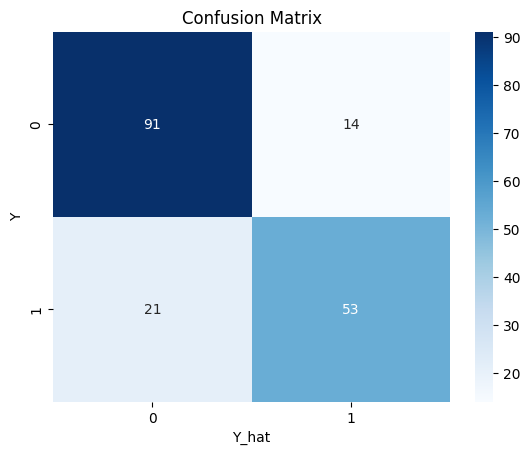

In [159]:
cm = compute_confusion_matrix(Y_test,Y_hat)
sns.heatmap(cm,annot=True,fmt='d',cmap='Blues')
plt.xlabel('Y_hat')
plt.ylabel('Y')
plt.title('Confusion Matrix')
plt.show()

##### ROC curve

In [160]:
# initializing empty arrays for store each precision and recall values for precision recall curve
Precision= []
Recall = []

In [161]:
def roc_curve(Y,Y_proba):
    thresholds = np.linspace(1,0,200)

    tpr_list = []
    fpr_list = []

    for t in thresholds:
        y_hat = (Y_proba >= t).astype(int)
        
        TP = np.sum((Y == 1) & (y_hat == 1))
        FP = np.sum((Y == 0) & (y_hat == 1))
        TN = np.sum((Y == 0) & (y_hat == 0))
        FN = np.sum((Y == 1) & (y_hat == 0))

        tpr = TP / (TP + FN)
        fpr = FP / (FP + TN)

        if (TP + FP) == 0:
            precision = 0 
        else:
            precision = TP / (TP + FP)

        recall = TP / (TP +FN)
        
        tpr_list.append(tpr)
        fpr_list.append(fpr)
        Precision.append(precision)
        Recall.append(recall)

    return np.array(tpr_list), np.array(fpr_list), np.array(thresholds)

In [162]:
tpr, fpr, _ = roc_curve(Y_test,Y_proba)

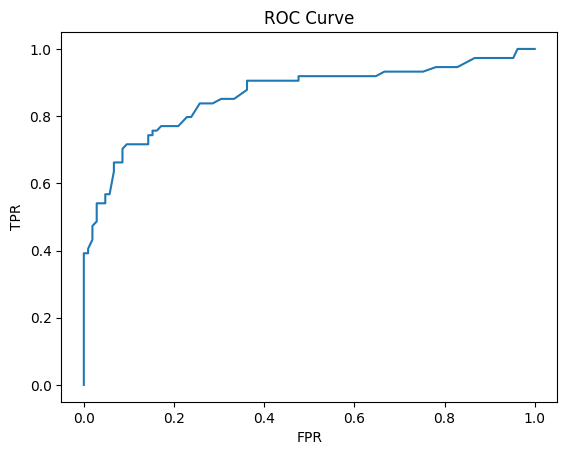

In [163]:
plt.plot(fpr, tpr, label='LogReg')
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curve")
plt.show()

In [164]:
auc = np.trapezoid(tpr, fpr)
print(f"AUC: {auc}")

AUC: 0.8631274131274131
